## Machine Learning Model Building Harness for Image Classification

### High-level Explanation of Harness:

Given a dataframe of image urls and labels, the harness 
- splits the data into train and test
- grabs the pixels from the url
- defines a pre-specified model
- trains the model on the training set for a given # of epochs and batch size
- tests the model on the test set
- plots two diagnostics: accuracy and cross-entropy loss over each epoch

To clarify, the diagostic data is only gathered from calculating the accuracy of the model on the test data at each epoch, but the model does NOT actually train on the test data.


### Functions:

**prep_pixels**           - Simply normalizes the training and testing data. Currently not being used.  
**summarize_diagnostics** - Plots cross entropy loss and (validation) accuracy.  
**run_test_harness**      - Main harness used to run the full model from start to finish. You specify all the parameters here.  
**load_server_dataset**   - Loads the data given a `folder_name`, which is either ny_dataset, fremont_dataset, or sa_dataset.  
**define_model**          - Creates a model that has the `.fit` and `.evaluate` methods.

**load_binary_dataset**   - Loads in data from a customized inside/outside binary dataset compiled from all available server data  
**load_one_dataset**      - Loads in the specified server dataset (i.e. fremont, san antonio, new york)  
**load_all_dataset**      - Loads in all of the server datasets available (i.e. fremont, san antonio, new york)

To create your own model, simply alter the `define_model` function, and make sure that the model you created has those two methods.  

Also, make sure that your preprocessing in `load_server_dataset` is appropriate for the data you are using. Currently, the data is filtering for only images with > 90% probability of being the label according to `realtor.com`. 

---

Model architecture (as of 12/4/20):   
- input_shape: (100, 100, 3)
- using VGG16 pre-trained layers up until the flattened layers
- there, we added 2 layers of 512 hidden nodes, and then a softmax output layer
- in the future, can consider preprocessing the data by standardizing the features or rotating images for more robust performance
- can also consider adding dropout layers, which we can hopefully test with more varied data (model already hit 100% test accuracy)

Hyperparameter tuning results:  
lr = 0.05  
batch_size = 60

Other hyperparameters (not hyperparameter tuned since we already hit 100% test accuracy on the data in the server):  
- L2 regularization = None
- image size/shape

In [34]:
# preprocessing
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import cv2
# modeling 
from skimage import io
import skimage
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Dropout, BatchNormalization
from keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
import tensorflow as tf


def prep_pixels(train, test):
    '''Normalizes training and test pixels
    Input: TRAIN and TEST image arrays
    Returns: Normalized TRAIN and TEST sets 
    * currently not used; using it caused our model to perform poorly (~40% accuracy)
    '''
    train_norm = train.astype('float32') / 255.0
    test_norm = test.astype('float32') / 255.0
    return train_norm, test_norm
 

# plot diagnostic learning curves
def summarize_diagnostics(history, testX, testY):
    '''Plots diganostic learning curves of the model 
    Inputs: - HISTORY object generated during model fitting that maintains loss values and relevant metrics
            - TESTX and TESTY image arrays used for validating accuracy
    Returns: - Two graphs (cross entropy loss and validation accuracy) plotted over the number of epochs. 
               Results are saved in a diagnostics folder under the same directory. 
    '''
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    # save plot to file
    plt.savefig('diagnostics/vgg16_diagnostic_plot_vl.png')
    plt.close()



def load_binary_dataset():
    '''Loads in data from custom binary dataset.
    Note: The classes and probability percentage are pre-specified in this function. 
    Please change as necessary.
    '''
    df = pd.read_csv('combined_binary_dataset.csv')
    df = df[df['probability'] > 0.90]
    classes = ['inside', 'outside']
    print('Classes: ', classes)
    return df, classes



def load_one_dataset(folder_name):
    '''Loads in data from a specific folder.
    Note: The classes and probability percentage are pre-specified in this function. 
    Please change as necessary.
    '''
    # read in filelist and rename columns
    df = pd.read_csv(f'{folder_name}/filelist', sep=" ", header=None)
    df.columns = ['link', 'filepath', 'class', 'probability']
    # filter
    classes = ['living_room', 'house_view', 'kitchen', 'yard', 'garage']
    df = df[df['probability'] > 0.90]
    df = df[df['class'].isin(classes)]
    print('Classes: ', classes)
    return df, classes



def load_all_dataset():
    '''Loads in data from all three datasets instead of for a specific folder.
    Note: The classes and probability percentage are pre-specified in this function. 
    Please change as necessary.
    '''
    folders = ['ny_dataset', 'fremont_dataset', 'sa_dataset']
    all_df = pd.DataFrame()
    for folder_name in folders: 
        df = pd.read_csv(f'{folder_name}/filelist', sep=" ", header=None)
        df.columns = ['link', 'filepath', 'class', 'probability']
        df = df[df['probability'] > 0.90]
        all_df = all_df.append(df)
        
    # change the label of all the classes with less than 20 images into `unknown`
    all_classes = all_df['class'].value_counts()
    all_df.loc[all_df['class'].apply(lambda x: x in all_classes.index[all_classes < 20]).values, 'class'] = 'unknown'
    classes = all_df['class'].unique()
    print('Classes: ', classes)
    return all_df, classes




def load_server_dataset(folder_name, test_size, random_state, n, shape):
    '''
    Given a folder name on Materiall's shared server:
    (1) reads in data files, 
    (2) convert them to pixels, 
    (3) separate them into train and testing data 
        (default test_size and random_state for reproducibility)
    Returns: X_train, X_test, y_train, y_test, shape of each image, num_of_classes
    '''
    if folder_name == 'all':
        df, classes = load_all_dataset()
    elif folder_name == 'binary':
        df, classes = load_binary_dataset()
    else: 
        df, classes = load_one_dataset(folder_name)

    # change dataset size if specified
    if n > 0:
        df = df.sample(n)
    print("Number of observations: " + str(df.shape[0]))

    # add pixels column, resize images (not proportional)
    df['pixels'] = df['link'].apply(lambda x: resize(io.imread(x), shape)) #might take a while

    #split and return training and test sets
    X = np.array([x for x in df['pixels']])
    y = df['class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # integer encode target labels so that keras can one hot
    label_encoder = LabelEncoder()
    vec_train = label_encoder.fit_transform(y_train)
    vec_test = label_encoder.fit_transform(y_test)

    # one hot encode target values
    y_train = to_categorical(vec_train)
    y_test = to_categorical(vec_test)

    #trainX, trainY, testX, testY 
    #(make sure ordering is correct to match harness function)
    return X_train, y_train, X_test, y_test, shape, classes



# define cnn model
def define_model(classes, shape, lr, momentum, verbose):
    '''Defines the CNN model used to fit to the training data'''

    # grab the pre-trained VGG16 model, removing the top layers and changing the input shape
    vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=shape)
        
    # freeze pre-trained layers
    for layer in vgg_model.layers:
        layer.trainable = False

    # add new classifier layers
    flat1 = Flatten()(vgg_model.layers[-1].output)
    class1 = Dense(512, activation='relu')(flat1)
    class2 = Dense(512, activation='relu')(class1)
    output = Dense(len(classes), activation='softmax')(class2)

    # define new model with top layers
    model = Model(inputs=vgg_model.inputs, outputs=output)
    opt = SGD(lr=lr, momentum=momentum)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # for output while training
    if verbose > 0:
        model.summary()

    return model


    
# MAIN() - runs the test harness for evaluating a model
def run_test_harness(folder_name, epochs=100, batch_size=64, 
                    verbose=2, test_size=0.1, random_state=100, 
                    n=-1, shape = (100, 100, 3), diagnostics = True, lr=0.05):
    '''
    The main() function used to load, fit, and evalute the model given the following params: 
    (1) FOLDER_NAME which specifies the type of model/data used (i.e. all, binary, specific folder) 
    (2) Optional hyperparamters used to fit the model
    Returns the MODEL created - progress and/or status of the model created/fitted will be printed/logged
    '''

    # load dataset
    trainX, trainY, testX, testY, shape, classes = load_server_dataset(folder_name, test_size, random_state, n, shape)
    print('Dataset Loaded!')
    # any pixel preprocessing will occur here

    # define model
    print('Defining Model...')
    model = define_model(classes, shape, lr=lr)

    # fit model
    print('Fitting Model...')
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_data=(testX, testY), verbose=verbose)
    print('Model fitted! Epochs=%d, Batch Size=%d' % (epochs, batch_size))

    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=verbose)
    print('Model Evalution:')
    print('> %.3f' % (acc * 100.0))

    # learning curves
    if diagnostics:
        summarize_diagnostics(history, testX, testY)
    print('----FINISHED----')
    return model

In [26]:
# optional params: epochs=100, batch_size=64, verbose=2, test_size=0.1, random_state=100, n=-1, shape = (100, 100, 3)
run_test_harness('all', epochs=25, test_size = 0.1, shape=(100, 100, 3), batch_size=60, lr = 0.05)

Classes:  ['unknown' 'kitchen' 'bathroom' 'bedroom' 'house_view' 'living_room'
 'road_view' 'yard' 'porch' 'dining_room' 'porch_yard' 'garage']
Number of observations: 1336
Dataset Loaded!
Defining Model...
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_____________________________________________

In [36]:
# Binary Version (indoor/outdoor):
# run_test_harness('binary', epochs=15, shape=(100, 100, 3), batch_size=60, lr = 0.05)

# Specific Dataset Version (e.g. fremont):
# run_test_harness('fremont_dataset', epochs=15, shape=(100, 100, 3), batch_size=60, lr = 0.05)

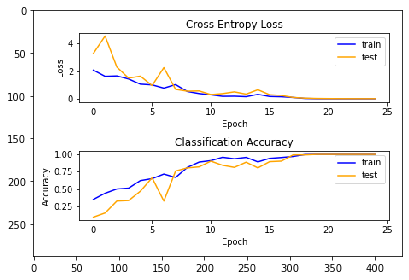

In [30]:
#visualize saved image plots
io.imshow('diagnostics/vgg16_diagnostic_plot_vl.png')